In [2]:
%load_ext autoreload
%autoreload 2

import torch
from einops import rearrange
from text3d2video.artifacts.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.feature_visualization import RgbPcaUtil
import text3d2video.wandb_util as wu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mv_features_tag = "deadpool-mv-features:latest"
mv_features = MVFeaturesArtifact.from_wandb_artifact_tag("deadpool-mv-features:v9")

In [4]:
layers = mv_features.get_key_values("layer")
views = sorted([int(v) for v in mv_features.get_key_values("view")])
timesteps = sorted([int(t) for t in mv_features.get_key_values("timestep")])

In [7]:
for layer in layers:
    shape = mv_features.get_feature_shape(layer)

    print(layer, shape)

/home/jorge/thesis/text3d2video/artifacts/multiview_features_artifact.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.Tensor(torch.load(feature_paht))


up_blocks.1.attentions.2.transformer_blocks.0.attn1 torch.Size([256, 1280])
down_blocks.0.attentions.0.transformer_blocks.0.attn1 torch.Size([4096, 320])
up_blocks.3.attentions.2.transformer_blocks.0.attn1 torch.Size([4096, 320])
down_blocks.0.attentions.1.transformer_blocks.0.attn1 torch.Size([4096, 320])
up_blocks.3.attentions.1.transformer_blocks.0.attn1 torch.Size([4096, 320])
up_blocks.2.attentions.2.transformer_blocks.0.attn1 torch.Size([1024, 640])
up_blocks.2.attentions.0.transformer_blocks.0.attn1 torch.Size([1024, 640])
down_blocks.2.attentions.0.transformer_blocks.0.attn1 torch.Size([256, 1280])
down_blocks.1.attentions.0.transformer_blocks.0.attn1 torch.Size([1024, 640])
down_blocks.2.attentions.1.transformer_blocks.0.attn1 torch.Size([256, 1280])
down_blocks.1.attentions.1.transformer_blocks.0.attn1 torch.Size([1024, 640])
up_blocks.3.attentions.0.transformer_blocks.0.attn1 torch.Size([4096, 320])
up_blocks.1.attentions.0.transformer_blocks.0.attn1 torch.Size([256, 1280])


In [7]:
from math import sqrt
from typing import List
from text3d2video.ipython_utils import display_ims


def display_features(features: List[torch.Tensor], separate_pca=False, scale=3):

    if separate_pca:
        feature_maps_rgb = []

        for feature in features:
            pca = RgbPcaUtil.init_and_fit(feature)
            feature_map_size = int(sqrt(feature.shape[0]))
            feature_map = rearrange(feature, "(h w) c -> c h w", h=feature_map_size)
            feature_map_rgb = pca.feature_map_to_rgb_pil(feature_map)
            feature_maps_rgb.append(feature_map_rgb)

        display_ims(feature_maps_rgb, scale=scale)
        return

    # get all features, and fit PCA
    all_features = torch.cat(features)
    pca = RgbPcaUtil.init_and_fit(all_features)

    # PCA each feature
    feature_maps_rgb = []
    for feature in features:
        feature_map_size = int(sqrt(feature.shape[0]))
        feature_map = rearrange(feature, "(h w) c -> c h w", h=feature_map_size)
        feature_map_rgb = pca.feature_map_to_rgb_pil(feature_map)
        feature_maps_rgb.append(feature_map_rgb)

    display_ims(feature_maps_rgb, scale=scale)

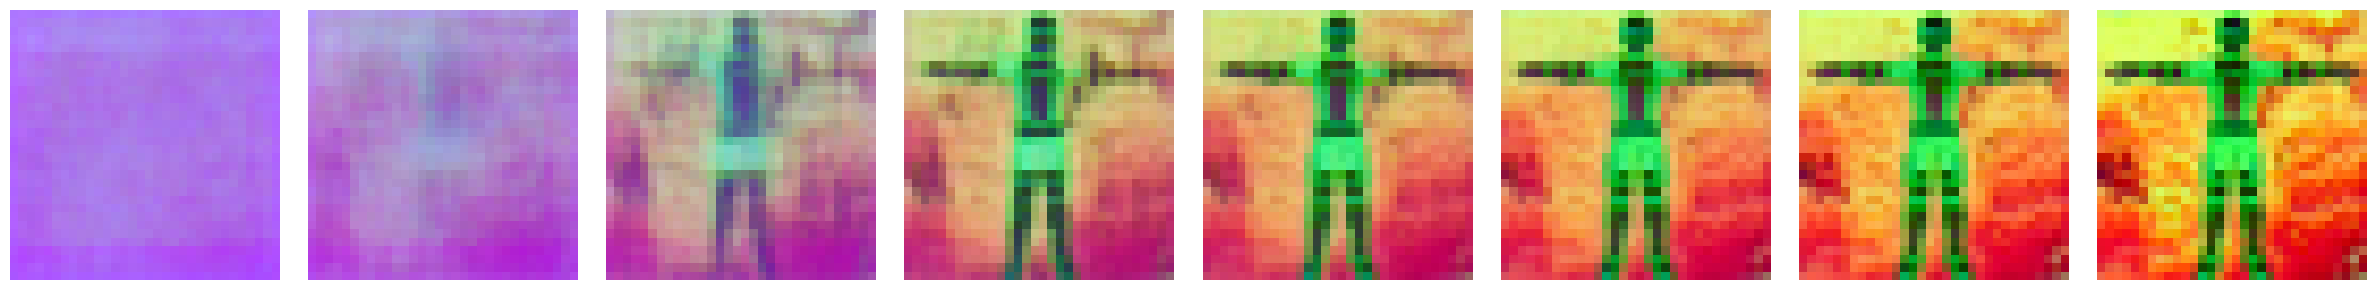

In [8]:
from text3d2video.util import ordered_sample

ids = [
    {"view": views[0], "layer": layers[0], "timestep": t}
    for t in ordered_sample(timesteps, 8)
]
features = [mv_features.get_feature_by_id(i) for i in ids]
display_features(features)

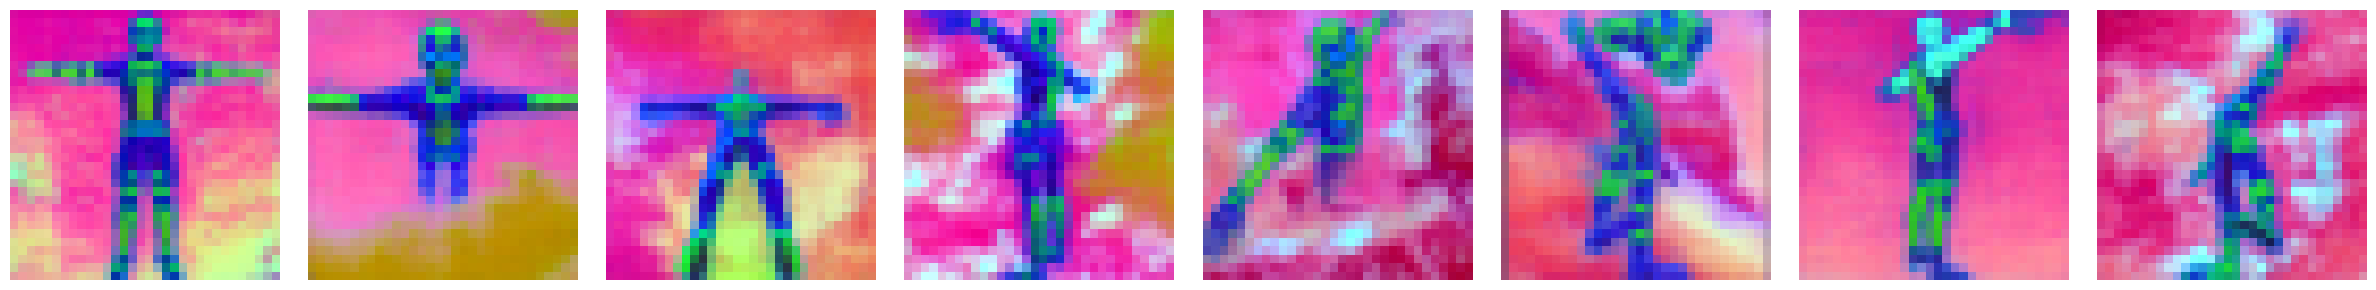

In [9]:
ids = [
    {"view": v, "layer": layers[0], "timestep": timesteps[20]}
    for v in ordered_sample(views, 8)
]
features = [mv_features.get_feature_by_id(i) for i in ids]
display_features(features)

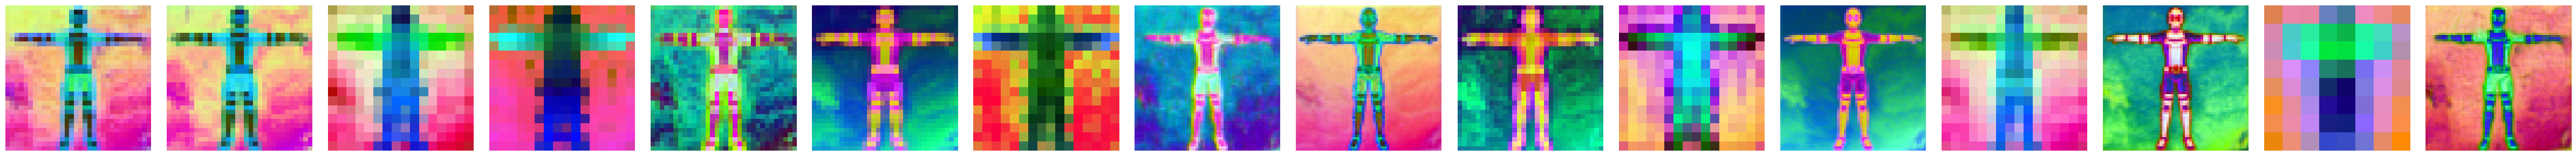

In [10]:
ids = [{"view": views[0], "layer": l, "timestep": timesteps[20]} for l in layers]
features = [mv_features.get_feature_by_id(i) for i in ids]

display_features(features, separate_pca=True)